# Problèmes inverses - Régularisation - Compressed sensing

## 1 - Problèmes pénalisés et contraints

Remarquons premièrement que f et g sont 2 fonctions strictement convexes et de domaines de définition commun $R^{N}$, il existe pour tout $\lambda \in R$ un minimiseur du problème i). Faisons également l'hypothèse de différentiabilité des fonctions.

Rappelons les conditions de Karush Kuhn-Tucker pour l'optimalité: 

> Soit un problème général: 

$$min f(x)$$ 

$$ s.c,  h_i(x) ≤ 0 \forall i \in I $$ 

Alors si $x^*$ est une solution du problème, les conditions suivantes sont vérifiées: 

$$ \nabla f(x^*) + \sum\limits_I\lambda_i\nabla h_i(x^*) = 0$$  

$$\lambda_ih_i(x^*) = 0,  \forall i \in I$$

$$ h_i(x^*) ≤ 0,  \forall i \in I$$

$$\lambda_i ≥ 0, \forall i \in I$$

> ii) => i) Soit $\epsilon \in R$, si il existe un minimiseur du problème ii) pour $\epsilon$, alors la condition de Karush Kuhn-Tucker nous permet d'affirmer en définissant la fonction $h(x) = g(x) - \epsilon$ qu'il existe un couple $(x_\lambda, \lambda)$ tel que le gradient du lagrangien du problème $L(x,\lambda) = f(x)+\lambda h(x)$ s'annule en ce point. C'est à dire, $f'(x_\lambda) + \lambda g'(x_\lambda) = 0$. Donc puisque f et g sont strictement convexes, qu'il existe une solution au problème $argmin_{R^{N}} f(x) + \lambda g(x)$


> i) =< ii) $\forall \lambda \in R+$, La fonction  $f(x) + \lambda g(x)$ admettant un minimiseur $x_\lambda$, alors les conditions de Karush Kuhn-Tucker pour le problème ii) sont uniquement vérifiés pour $h(x) = g(x) - g(x_\lambda)$ c'est à dire ($\epsilon = g(x_\lambda)$). Ainsi puisque le problème ii) admet une unique solution par stricte convexité de la fonctions f sur le domaine $\{x \in R ;g(x)≤\epsilon\}$, il existe $x_\epsilon$ minimiseur du problème i) dépendant de $\lambda$.


## 1 - Déconvolution 1D

Trois signaux s1, s2 et s3 de longueur L = 99 sont observés (vecteurs m1, m2 et m3) à travers un filtre de réponse impulsionnelle h (fichier signaux1D.mat).
Ces signaux possèdent les propriétés suivantes : 
> **s1 : variations lentes**

> **s2 : somme de quelques impulsions**

> **s3 : signal constant par morceaux**

In [868]:
import cvxpy as cp
import cvxopt
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy
from scipy import signal
import scipy.fftpack as fft
from matplotlib.pyplot import cm

In [258]:
mat = scipy.io.loadmat('tp1 (1)/Signaux1D.mat')
filtre = scipy.io.loadmat('tp1 (1)/h.mat')

In [1013]:
h = filtre['h'].flatten()
m1 = mat['m1'].flatten()
m2 = mat['m2'].flatten()
m3 = mat['m3'].flatten()

### a - Réponse fréquentielle et Conditionnement 

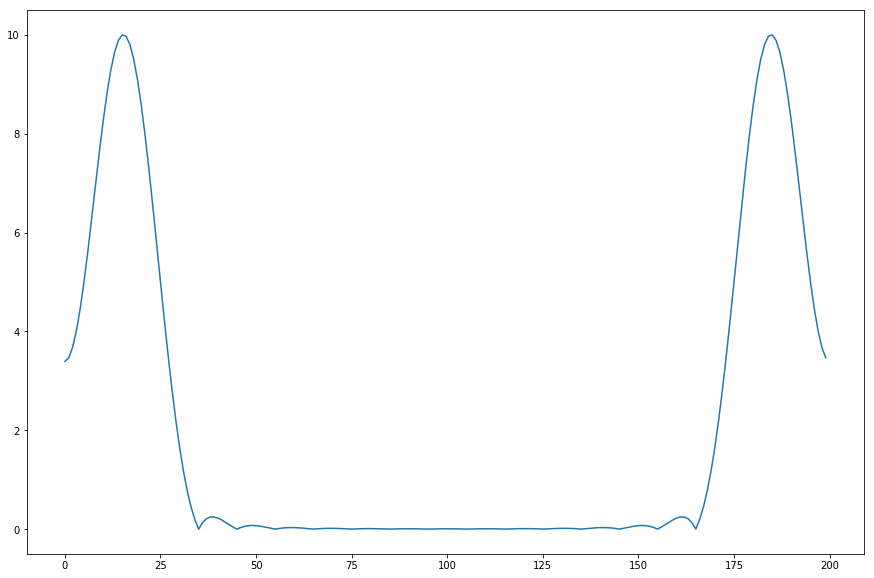

In [139]:
plt.figure(figsize=(15,10))
rep = np.abs(np.fft.fft(h, 200))
plt.plot(rep)
K = np.max(rep)/np.min(rep)
print('Condiotionnement du filtre = ',K)

**Obesevration** Le filtre est très mal conditionné car le rapport est très grand entre la norme du noyau de convolution et son inverse. On rapelle qu'un conditionnement élevé du filtre aura comme conséquence une amplification du bruit dans l’estimation.

### b - Routine de régularisation (reconstruction et paramètre de régularisation optimal) à l'aide de l'outil cvxpy 

In [22]:
def loss_fn(X, Y):
    return cp.pnorm(cp.conv(h,X) - Y[:,np.newaxis], p=2)**2

def regularizer(X,type_reg=2):
    if type_reg==2:
        return cp.pnorm(X, p=2)**2
    elif type_reg==1:
        return cp.pnorm(X, p=1)
    elif type_reg=='vt':
        return cp.tv(X)

def objective_fn(X, Y, lambd, type_reg):
    return loss_fn(X, Y) + lambd * regularizer(X,type_reg)

def regularisation(Y, type_reg=2, lambda_=0.01):

    X = cp.Variable(99)
    lambd = cp.Parameter(nonneg=True)
    lambd.value = lambda_
    problem = cp.Problem(cp.Minimize(objective_fn(X, Y, lambda_, type_reg)))
    problem.solve()
    return X

val = regularisation(m1, type_reg=2, lambda_=0.1)

### Signal s1

La régularisation proposée ici est une régularisation par norme $l_2$ pour favoriser une reconstruction du signal possèdant des variations lentes. 

In [137]:
lambd_values = np.logspace(-2, 1, 50)
value=[]
loss=[]
Phi=[]
for v in lambd_values:
    val = regularisation(m1, type_reg=2, lambda_=v)
    value.append(val.value)
    loss.append(np.linalg.norm(np.convolve(h,val.value)-m1)**2)
    Phi.append(float(regularizer(val.value,2).value))

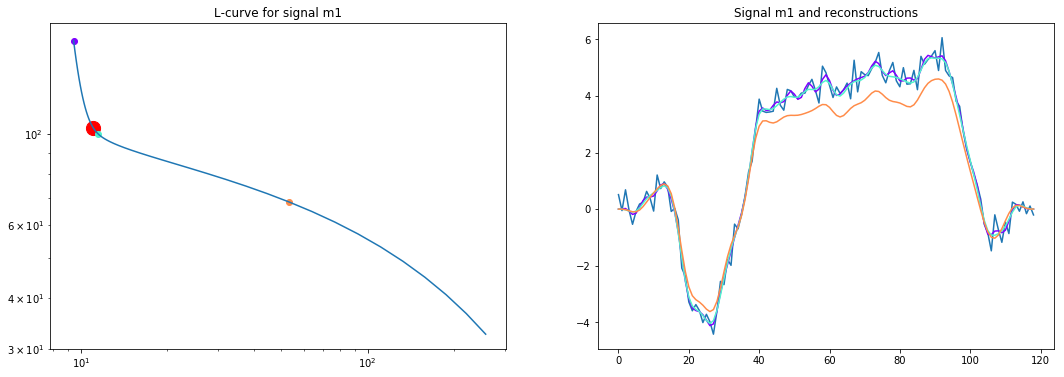

In [138]:
curvature = [(np.log(loss[i])*np.log(Phi[i+1]) 
              - np.log(Phi[i])*np.log(loss[i+1]))
             /(np.log(Phi[i])**2 + np.log(loss[i])**2)**(3/2) 
             for i in range(1,49)]
c_max = np.argmax(curvature)
fig, a = plt.subplots(1,2, figsize=(18,6))
a[0].loglog(loss,Phi)
a[0].set_title('L-curve for signal m1')
a[1].plot(m1)
a[1].set_title('Signal m1 and reconstructions')
a[0].scatter(loss[c_max],Phi[c_max], color='red', s=200)
color=cm.rainbow(np.linspace(0,1,50))
for i in range(0,50,20):
    a[0].scatter(loss[i],Phi[i], color=color[i])
    a[1].plot(cp.conv(h,value[i]).value,color=color[i])

#### Algorithme retenu: Explicitation directe de la solution ou descente de gradient

La fonction $\|h\star x - y \|_2^2 - \lambda\|x\|_2^2$ est équivalente, par isométrie de la transformée de Fourier, à minimiser un $\|H \circ X-Y\|_2^2 - \lambda\|X\|_2^2$  dans l'espace fréquentiel. Cette dernière fonction admet un minimiseur comme somme de 2 fonctions convexes. Par conséquent, l'algorithme de descente de gradient va permettre d'aboutir au minimum global. En réalité, le problème admet même un forme close dans le domaine fréquentiel égale à $((H^*\circ H + \lambda) I_N)^{-1}H^*Y$

D'autre part, il est aussi possible d'exprimer la convolution comme une multiplication matricielle à l'aide d'une matrice de Toplietz adéquate. Cette formulation nous permet alors de minimiser directement dans le domaine temporelle le signal régularisé dont l'expression est $arg\min_{R^{N}} \|H_{conv}x -y\|_2^2 - \lambda\|x\|_2^2$

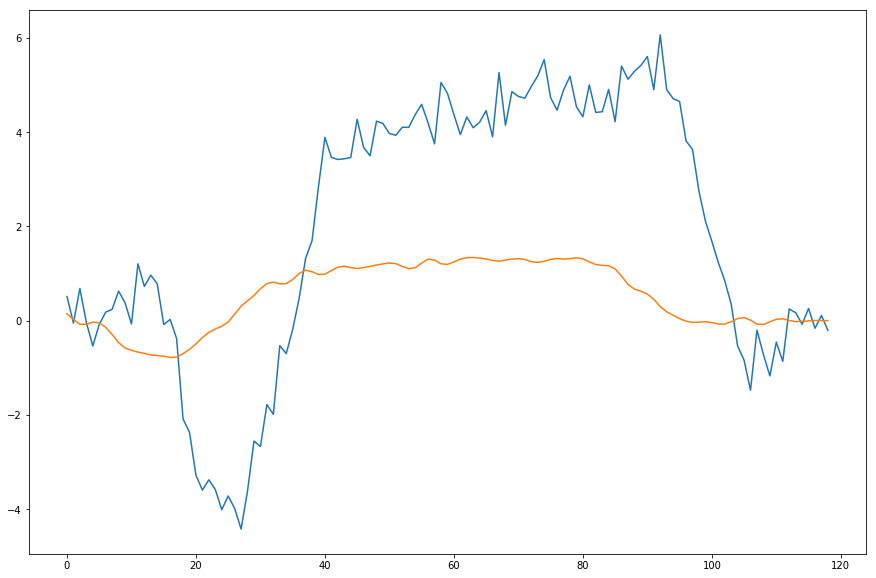

In [1398]:
padding1 = np.zeros(98, h.dtype)
padding2 = np.zeros(118, h.dtype)
first_col = np.r_[h, padding1]
first_row = np.r_[h[0], padding2]
H = scipy.linalg.toeplitz(first_col, first_row)

plt.figure(figsize=(15,10))
plt.plot(m1)
plt.plot(np.linalg.inv(H.T@H + 1*np.eye(H.shape[1]))@(H.T.dot(m1)))

## Signal s2

Nous savons que le signal est la somme de quelques impulsions, nous volons donc imposer un signal parcimonieux, la régularisation proposée ici est une régularisation par norme $l_1$ sur le signal lui-même.

In [123]:
lambd_values = np.logspace(-2, 1.5, 50)
value=[]
loss=[]
Phi=[]
for v in lambd_values:
    val = regularisation(m2, type_reg=1, lambda_=v)
    value.append(val.value)
    loss.append(np.linalg.norm(np.convolve(h,val.value)-m2)**2)
    Phi.append(float(regularizer(val.value,2).value))

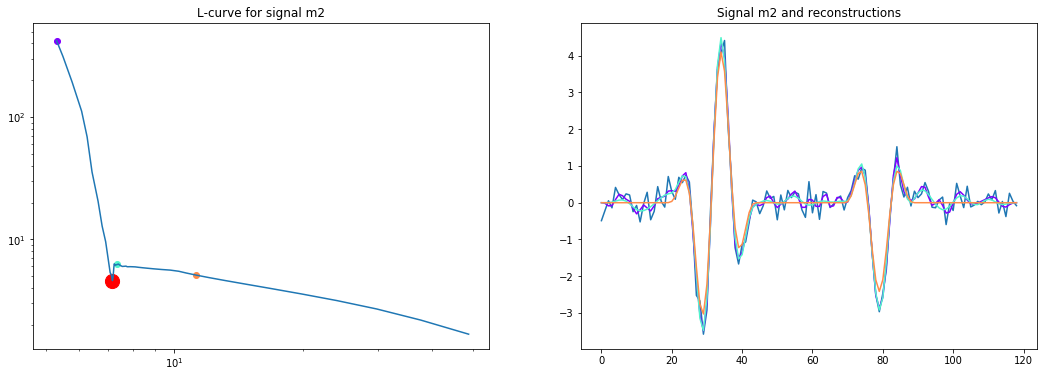

In [124]:
curvature = [(np.log(loss[i])*np.log(Phi[i+1]) 
              - np.log(Phi[i])*np.log(loss[i+1]))
             /(np.log(Phi[i])**2 + np.log(loss[i])**2)**(3/2) 
             for i in range(1,49)]
c_max = np.argmax(curvature)

fig, a = plt.subplots(1,2, figsize=(18,6))
a[0].loglog(loss,Phi)
a[0].set_title('L-curve for signal m2')
a[1].plot(m2)
a[1].set_title('Signal m2 and reconstructions')
a[0].scatter(loss[c_max],Phi[c_max], color='red', s=200)
color=cm.rainbow(np.linspace(0,1,50))
for i in range(0,50,20):
    a[0].scatter(loss[i],Phi[i], color=color[i])
    a[1].plot(cp.conv(h,value[i]).value,color=color[i])

#### Algorithme retenu: Forward_Backward

In [1337]:
padding1 = np.zeros(98, h.dtype)
padding2 = np.zeros(118, h.dtype)
first_col = np.r_[h, padding1]
first_row = np.r_[h[0], padding2]
H = scipy.linalg.toeplitz(first_col, first_row)

def Forward_Backward(signal, H=H, beta=1, lambda_= 1/2, tol= 1e-5):
    
    nu = np.linalg.norm(H.T.dot(H))
    gamma = 2*(1/nu - 1e-5) 
    delta = 2 - gamma*nu/2    
    print('nu={}, gamma={}, delta={}, beta={}'.format(nu,gamma,delta,beta))
                 
    grad_g = lambda x: H.T.dot(H.dot(x)) - H.T.dot(signal)
    prox_f = lambda x: np.sign(x)*(np.clip(np.abs(x)-gamma*beta,0,np.inf))                 
    
    tolerance=1
                 
    x_n = np.ones(119) #np.random.uniform(0,1,200)
    count=0
                         
    while tolerance > tol and count<40000:
        count+=1
        if count%10000==0:
            print(count, tolerance, tol)
        if count%1000==0:
            lambda_=lambda_*0.99
                         
        y_n = x_n - gamma*grad_g(x_n)
        x_n1 = x_n + lambda_*(prox_f(y_n)-x_n)   
        tolerance = np.linalg.norm(x_n1 - x_n,2)/np.linalg.norm(x_n,1)
        x_n = x_n1
                 
    return x_n

nu=336.90724039937754, gamma=0.0059163520879787395, delta=1.0033690724039936, beta=0.03162277660168379
10000 1.9385832547682475e-05 1e-07
20000 5.118041072300706e-06 1e-07
30000 1.891428557968292e-06 1e-07
40000 9.920133655724283e-07 1e-07
nu=336.90724039937754, gamma=0.0059163520879787395, delta=1.0033690724039936, beta=0.1
10000 1.3181966849762638e-05 1e-07
20000 6.947714918031815e-06 1e-07
30000 2.0253166148089413e-06 1e-07
40000 3.019360296214053e-07 1e-07
nu=336.90724039937754, gamma=0.0059163520879787395, delta=1.0033690724039936, beta=0.31622776601683794
10000 5.141010016540322e-07 1e-07
nu=336.90724039937754, gamma=0.0059163520879787395, delta=1.0033690724039936, beta=1.0


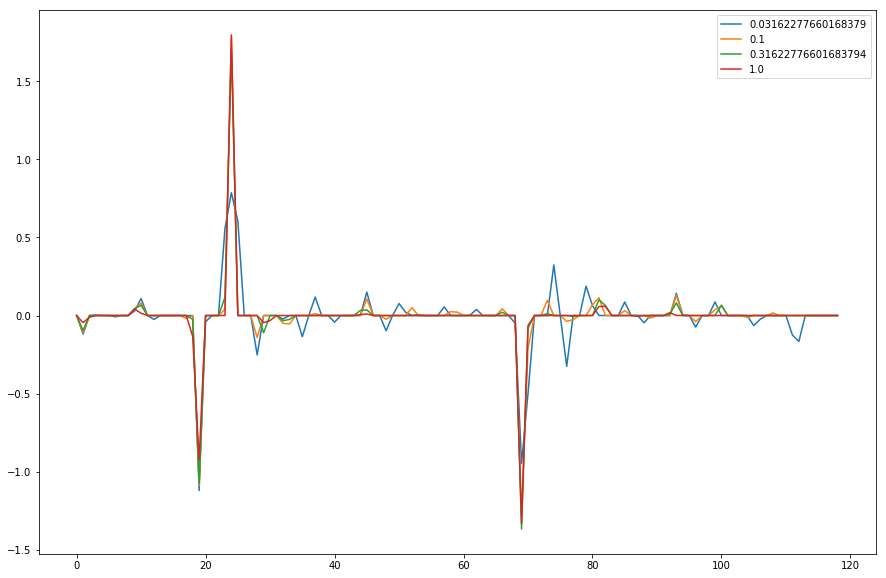

In [1338]:
plt.figure(figsize=(15,10))
for r in np.logspace(-1.5,0,4):
    essai = Forward_Backward(m2, H=H, beta=r,lambda_= 1/1.5, tol= 1e-7)
    plt.plot(essai,label='{}'.format(r))
plt.legend()

## Signal s3

Nous savons que le signal est continu par morceaux, ainsi, il semble logique d'imposer une parcimonie sur le gradient discret du signal, la régularisation proposée ici est donc une régularisation utilisant la norme de variation totale $\|.\|_{V_t}$.

In [119]:
lambd_values = np.logspace(-2, 2, 50)
value=[]
loss=[]
Phi=[]
for v in lambd_values:
    val = regularisation(m3, type_reg='vt', lambda_=v)
    value.append(val.value)
    loss.append(np.linalg.norm(np.convolve(h,val.value)-m3)**2)
    Phi.append(float(regularizer(val.value,1).value))

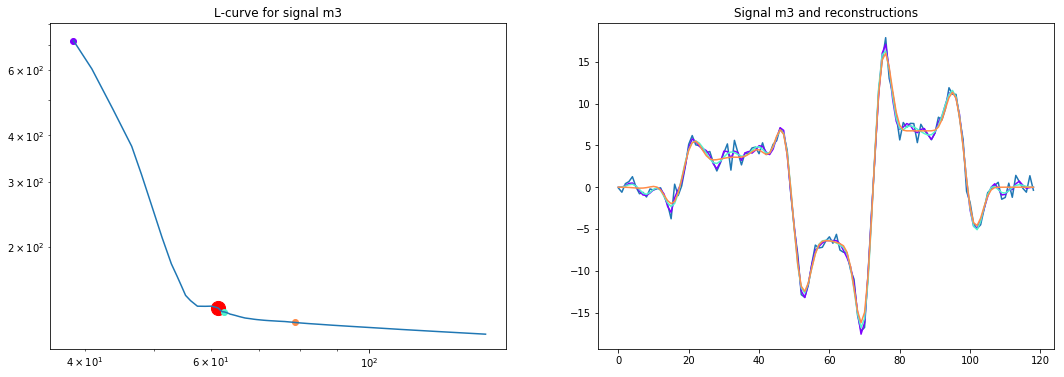

In [120]:
curvature = [(np.log(loss[i])*np.log(Phi[i+1]) 
              - np.log(Phi[i])*np.log(loss[i+1]))
             /(np.log(Phi[i])**2 + np.log(loss[i])**2)**(3/2) 
             for i in range(1,49)]
c_max = np.argmax(curvature)

fig, a = plt.subplots(1,2, figsize=(18,6))
a[0].loglog(loss,Phi)
a[0].set_title('L-curve for signal m3')
a[1].plot(m3)
a[1].set_title('Signal m3 and reconstructions')
a[0].scatter(loss[c_max],Phi[c_max], color='red', s=200)
color=cm.rainbow(np.linspace(0,1,50))
for i in range(0,50,20):
    a[0].scatter(loss[i],Phi[i], color=color[i])
    a[1].plot(cp.conv(h,value[i]).value,color=color[i])

#### Algorithme retenu: ADMM

In [1416]:
padding1 = np.zeros(98, h.dtype)
padding2 = np.zeros(118, h.dtype)
first_col = np.r_[h,padding1]
first_row = np.r_[h[0], padding2]
H = scipy.linalg.toeplitz(first_col, first_row)

D=np.eye(119)-np.eye(119,119,-1)
D[0,-1]=-1

def ADMM(signal, H=H, beta=0.1, gamma=1, tol= 1e-5):
    
    print('beta=',beta)
    prox_f1 = lambda y,z: -np.linalg.inv(H.T.dot(H) + D.T.dot(D))@(-H.T.dot(signal)+D.T.dot(y-z))
    prox_f2 = lambda x: np.sign(x)*(np.clip(np.abs(x)-gamma*beta,0,np.inf))
                                              
    u_n = np.ones(119)     
    z_n = np.ones(119)
    tolerance=1
    x_n_prev = np.ones(119)
    count=0
    
    while tolerance > tol and count<40000: 
        count+=1
        if count%10000==0:
            print(count, tolerance, tol)
            
        x_n = prox_f1(u_n,z_n) 
        s_n = D.dot(x_n)
        z_n1 = prox_f2(u_n + s_n)
        u_n1 = u_n + s_n - z_n1
        
        tolerance = np.linalg.norm(x_n - x_n_prev,1)/np.linalg.norm(x_n_prev,1)
        x_n_prev = x_n
        z_n = z_n1
        u_n = u_n1
        
    return x_n


beta= 0.31622776601683794
beta= 0.5623413251903491
beta= 1.0


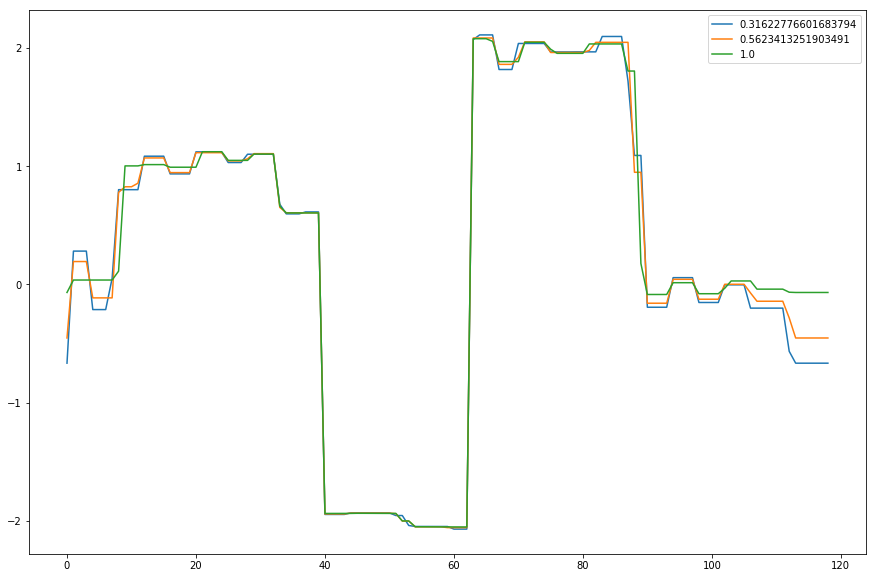

In [1417]:
plt.figure(figsize=(15,10))
for r in np.logspace(-0.5,-0,3):
    essai = ADMM(m3, H=H, beta=r, gamma=1, tol= 1e-6)
    plt.plot(essai,label='{}'.format(r))
plt.legend()

#### Annexe:  Signal amplitudes given regularization parameter

Nous voyons que les régularizations ont un effet différent sur les amplitudes des valeurs du signal. La norme $l_1$ "forçant" les valeurs du signal à être nulles.

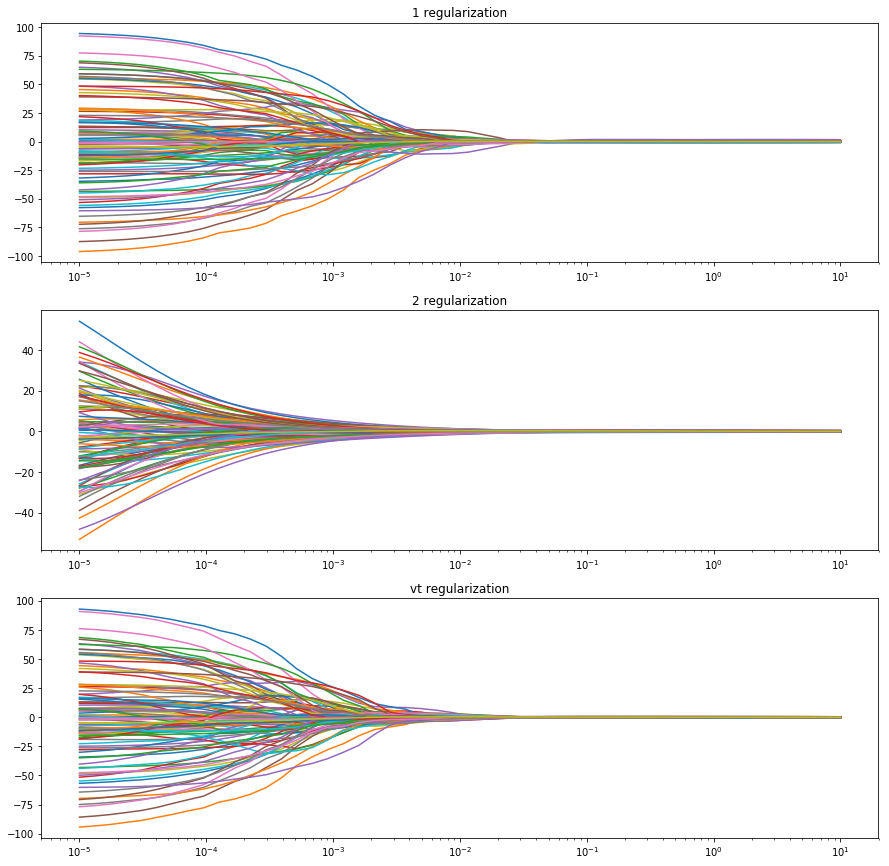

In [81]:
lambd_values = np.logspace(-5, 1, 50)
fig, a = plt.subplots(3,1, figsize=(15,15))
loss = {}
Phi = {}
value= {}
for k,i in enumerate([1,2,'vt']):
    value[i]=[]
    loss[i]=[]
    Phi[i]=[]
    for v in lambd_values:
        val = regularisation(m2, type_reg=i, lambda_=v)
        value[i].append(val.value)
        loss[i].append(float(loss_fn(val, m2).value))
        Phi[i].append(float(regularizer(val.value,i).value))
    a[k].plot(lambd_values,value[i])
    a[k].set_xscale('log')
    a[k].set_title('{} regularization'.format(i))

# Déconvolution 2D

Text(0.5, 1.0, 'image')

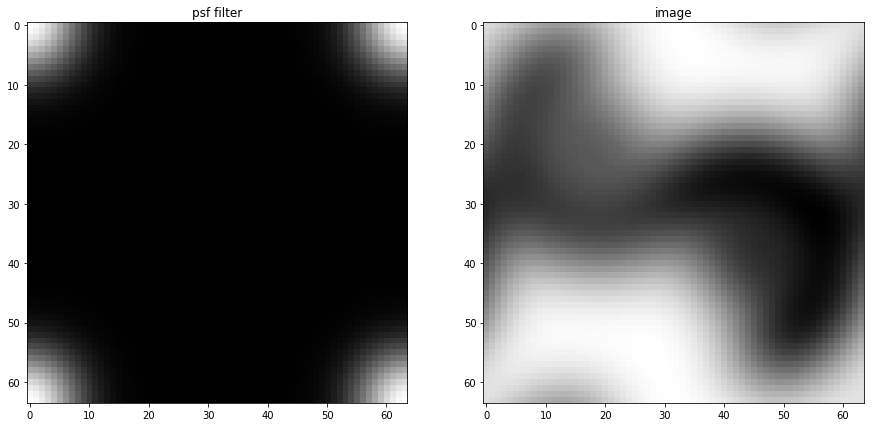

In [1172]:
img = scipy.io.loadmat('tp1 (1)/deconv_image.mat')
psf = img['PSF']
image = img['image']
i = [k+31 for k in range(32)] + [k for k in range(32)]
order = np.argsort(i)
#psf = psf[:,order][order,:]
fig, a = plt.subplots(1,2, figsize=(15,10))
a[0].imshow(psf,cmap='gray')
a[0].set_title('psf filter')
a[1].imshow(image,cmap='gray')
a[1].set_title('image')

### Tikhonov

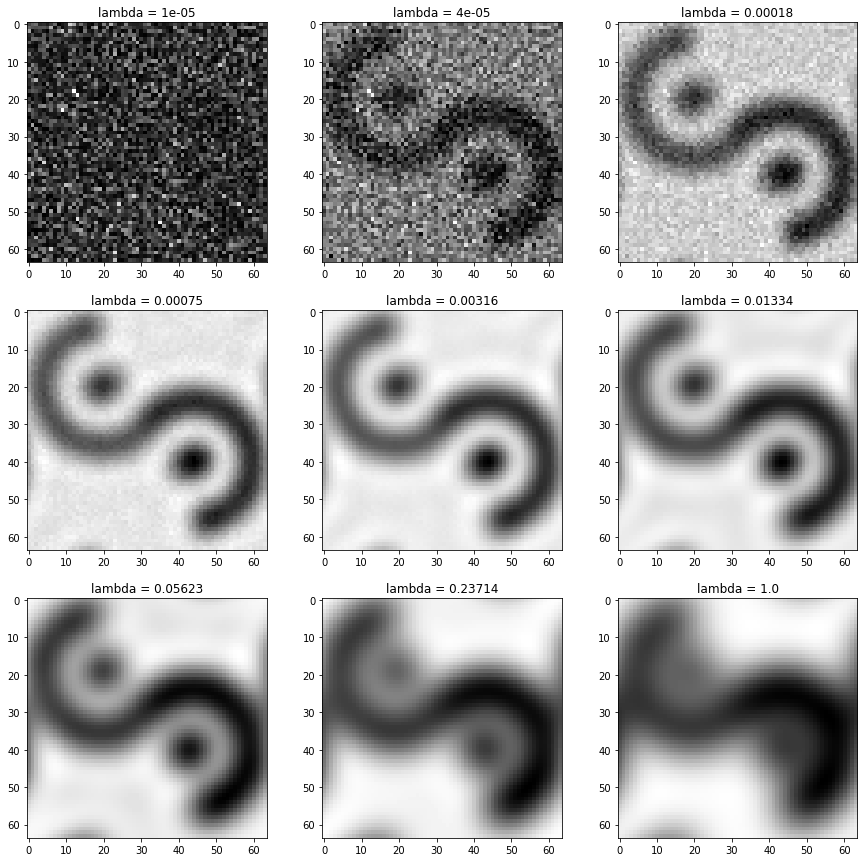

In [764]:
mat_psf = np.fft.fft2(img['PSF'])
mat_img = np.fft.fft2(img['image'])

lambd_values = np.logspace(-5, 0, 9)
fig, a = plt.subplots(3,3, figsize=(15,15))
for i,v in enumerate(lambd_values):
    estim = mat_img/(mat_psf+v)
    estim = np.abs(np.fft.ifft2(estim))
    a[i//3,i%3].imshow(estim,cmap='gray')
    a[i//3,i%3].set_title('lambda = {}'.format(round(v,5)))

### Variation totale

Sachant que l'image est composée de zones de luminosité constante, une régularisation par la norme de variation totale semble adaptée pour garantir une reconstruction qui favorise cette propriété. Nous formulons alors le problème dans le domaine fréquentiel afin de tirer parti des propriétés de la transformée de Fourier d'un produit de convolution et d'isométrie de la transformée de Fourier pour les normes utilisées.

$$ F(h*X) = F(h)\circ F(X)$$

$$\|F(X)\| = \|X\|$$

Ceci nous permet de formuler le problème de la manière suivante:

$$ \hat{X} = F^{-1}(\text{arg}\min_{R^{(64,64)}} \|F(h)\circ F(X)-F(Y)\|^{2}_2 + \lambda\|F(X)\|_{V_t})$$

où $\circ$ est le produit élément-à-élément des matrices.

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 23816, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 10000, normalize = 1, scale = 1.00
Variables n = 8067, constraints m = 16007
Cones:	soc vars: 16007, soc blks: 3971
Setup time: 2.63e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 7.49e+00  7.67e+00  1.00e+00 -3.80e+07  3.45e+07  1.75e-08  6.51e-02 
   100| 5.00e-03  4.62e-03  2.35e-02  3.56e+05  3.73e+05  8.58e-10  7.69e-01 
   200| 3.11e-03  3.13e-03  1.61e-02  3.95e+05  4.08e+05  9.67e-10  1.60e+00 
   300| 2.46e-03  2.32e-03  1.65e-02  4.0

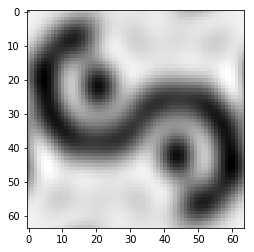

In [1424]:
mat_psf = np.fft.fft2(img['PSF'])
mat_img = np.fft.fft2(img['image'])

def loss_fn(X,Y):
    return cp.pnorm(cp.multiply(np.real(mat_psf),X) - np.real(Y) , p=2)**2

def regularizer(X):
    return cp.tv(X)

def objective_fn(X, Y, lambd):
    return loss_fn(X, Y)  + lambd * regularizer(X)

def regularisation(Y, lambda_=0.05):

    X = cp.Variable((64,64))
    X.value = np.zeros((64,64))
    lambd = cp.Parameter(nonneg=True)
    lambd.value = lambda_
    #constraint = [regularizer(X)<=10000000000] + [X[i,j]<=256 for i in range(64) for j in range(64)] + [X[i,j]>=0 for i in range(64) for j in range(64)]
    problem = cp.Problem(cp.Minimize(objective_fn(X, Y, lambda_)))
    problem.solve(verbose=True, solver=cp.SCS,max_iters=10000)
    return X, problem

val, prob = regularisation(mat_img)
test = np.real(np.fft.ifft2(val.value))
test[0,0]=np.mean(test)
plt.imshow(test,cmap='gray')


### Reformulation du problème de minimisation

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 23817, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 2500, normalize = 1, scale = 1.00
Variables n = 8067, constraints m = 16008
Cones:	linear vars: 1
	soc vars: 16007, soc blks: 3971
Setup time: 3.81e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 7.48e+00  9.91e+00  1.00e+00 -7.39e+08  6.72e+08  3.40e-07  8.03e-02 
   100| 4.77e-03  6.64e-03  1.83e-02  7.44e+06  7.72e+06  1.89e-08  8.93e-01 
   200| 4.11e-03  6.97e-03  2.53e-02  7.91e+06  8.32e+06  2.29e-08  1.85e+00 
   300| 3.47e-03  5.99e-03

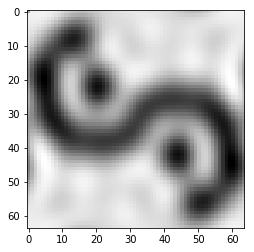

In [951]:
mat_psf = np.fft.fft2(img['PSF'])
mat_img = np.fft.fft2(img['image'])

def loss(X):
    return cp.tv(X)

def constraint_f(X, Y):
    return cp.pnorm(cp.multiply(np.real(mat_psf),X) - np.real(Y) , p=2)**2

def regularisation(Y, eps=10):

    X = cp.Variable((64,64))
    X.value = np.zeros((64,64))
    epsilon = cp.Parameter(nonneg=True)
    epsilon.value = eps
    constraint = [constraint_f(X, Y)<=epsilon]
    problem = cp.Problem(cp.Minimize(loss(X)),constraints=constraint)
    problem.solve(verbose=True, solver=cp.SCS)
    return X, problem

val, prob = regularisation(mat_img)
test = np.real(np.fft.ifft2(val.value))
test[0,0]=np.mean(test)
plt.imshow(test,cmap='gray')

# Partie 3: 1-Pixel Camera

In [793]:
one_pixel = scipy.io.loadmat('tp1 (1)/1px.mat')
A = one_pixel['Phi']
m1 = one_pixel['m1']
m2 = one_pixel['m2']
m3 = one_pixel['m3']

## 3-1 Reconstruction par méthode des moindres carrés

Nous testons ici une reconstructions par régularisation $l_2$ qui nous permet d'exprimer la solution unique du porblème comme $\hat{𝑋} = (A^{*}A+\lambda I_n)^{-1}A^{*}Y$ En revanche, malgré un bruit faible, la reconstruction est mauvaise du fait du faible nombre de mesures par rapport au nombre de pixels.



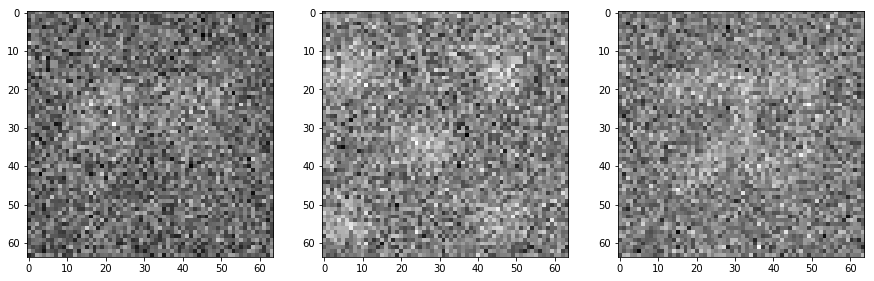

In [785]:
MC = np.linalg.inv(A.T@A+0.01*np.eye(4096))@A.T

fig ,a = plt.subplots(1,3, figsize=(15,10))
a[0].imshow((MC@m1).reshape(64,64),cmap='gray')
a[1].imshow((MC@m2).reshape(64,64),cmap='gray')
a[2].imshow((MC@m3).reshape(64,64),cmap='gray')

## 3-2 Reconstruction par régularisation par la norme de variation totale

A nouveau, nous emploierons la norme de variation totale pour reconstruire des images qui ont potentiellement des zones de luminosité constante. Ici le problème est posé de la manière suivante:

$$ \text{arg}\min_{R^{(64,64)}} \|AX-Y\|^{2}_2 + \lambda\|X\|_{V_t}$$

In [789]:
def loss_fn(X,Y):
    return cp.pnorm(A@X - Y.reshape(400), p=1)

def regularizer(X,):
    return cp.tv(cp.reshape(X,(64,64)))

def objective_fn(X, Y, lambd):
    return loss_fn(X, Y) + lambd * regularizer(X)

def regularisation(Y, lambda_=0.01):

    X = cp.Variable((4096))
    lambd = cp.Parameter(nonneg=True)
    lambd.value = lambda_
    problem = cp.Problem(cp.Minimize(objective_fn(X, Y, lambda_)))
    problem.solve(verbose=True)
    return X

In [790]:
val1 = regularisation(m1, lambda_=0.1)
val2 = regularisation(m2, lambda_=0.1)
val3 = regularisation(m3, lambda_=0.1)


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +2.909e-17  -1.366e-14  +2e+03  9e-01  1e-02  1e+00  3e-01    ---    ---    1  3  - |  -  - 
 1  -8.636e-04  +4.296e-07  +2e+01  8e-02  1e-04  1e-02  4e-03  0.9890  1e-04   3  2  2 |  0  0
 2  +2.779e-05  +3.919e-05  +2e-01  1e-03  2e-06  2e-04  5e-05  0.9860  1e-04   3  2  2 |  0  0
 3  +2.351e-03  +2.352e-03  +4e-02  2e-04  3e-07  3e-05  8e-06  0.8429  1e-02   3  2  3 |  0  0
 4  +6.952e-03  +6.951e-03  +2e-02  9e-05  1e-07  1e-05  4e-06  0.5886  6e-02   3  3  3 |  0  0
 5  +9.215e-03  +9.214e-03  +7e-03  3e-05  5e-08  3e-06  1e-06  0.7450  2e-01   4  3  3 |  0  0
 6  +9.934e-03  +9.933e-03  +3e-03  1e-05  2e-08  1e-06  6e-07  0.6610  1e-01   4  4  4 |  0  0
 7  +1.030e-02  +1.030e-02  +9e-04  5e-06  7e-09  3e-07  2e-07  0.8136  2e-01   4  4  4 |  0  0
 8  +1.042e-02  +1.042e-02  +4e-04  2e-06  3e-

27  +1.578e-02  +1.578e-02  +7e-08  2e-08  5e-13  1e-11  2e-11  0.0478  5e-01   2  1  1 |  0  0
28  +1.578e-02  +1.578e-02  +7e-08  2e-08  5e-13  1e-11  2e-11  0.0449  5e-01   2  1  1 |  0  0
29  +1.578e-02  +1.578e-02  +6e-08  2e-08  4e-13  1e-11  1e-11  0.4027  7e-01   2  1  1 |  0  0
30  +1.578e-02  +1.578e-02  +5e-08  1e-08  3e-13  8e-12  9e-12  0.3744  1e-01   2  1  1 |  0  0
31  +1.578e-02  +1.578e-02  +5e-08  1e-08  3e-13  8e-12  9e-12  0.0002  1e+00   2  1  1 |  0  0
32  +1.578e-02  +1.578e-02  +4e-08  2e-08  3e-13  8e-12  9e-12  0.0914  8e-01   2  1  0 |  0  0
33  +1.578e-02  +1.578e-02  +4e-08  2e-08  3e-13  8e-12  9e-12  0.0460  5e-01   2  1  1 |  0  0
34  +1.578e-02  +1.578e-02  +4e-08  1e-08  3e-13  7e-12  8e-12  0.1345  3e-01   2  1  1 |  0  0
35  +1.578e-02  +1.578e-02  +4e-08  1e-08  3e-13  7e-12  8e-12  0.1163  5e-01   2  1  1 |  0  0
36  +1.578e-02  +1.578e-02  +4e-08  1e-08  2e-13  7e-12  8e-12  0.1355  5e-01   2  1  1 |  0  0
37  +1.578e-02  +1.578e-02  +4e-08  1e-0

 8  +9.562e-02  +9.562e-02  +3e-03  1e-06  2e-08  7e-07  6e-07  0.8146  1e-01   4  3  3 |  0  0
 9  +9.602e-02  +9.602e-02  +7e-04  4e-07  5e-09  2e-07  2e-07  0.8807  2e-01   4  3  3 |  0  0
10  +9.612e-02  +9.612e-02  +3e-04  1e-07  2e-09  6e-08  6e-08  0.7675  2e-01   5  4  4 |  0  0
11  +9.616e-02  +9.616e-02  +1e-04  6e-08  9e-10  3e-08  3e-08  0.8199  3e-01   5  5  5 |  0  0
12  +9.618e-02  +9.618e-02  +2e-05  1e-08  2e-10  5e-09  5e-09  0.8642  5e-02   3  7  7 |  0  0
13  +9.618e-02  +9.618e-02  +1e-05  5e-09  7e-11  2e-09  2e-09  0.8446  4e-01   3  1  1 |  0  0
14  +9.619e-02  +9.619e-02  +2e-06  1e-09  1e-11  4e-10  4e-10  0.8467  2e-02   3  1  1 |  0  0
15  +9.619e-02  +9.619e-02  +7e-07  6e-10  5e-12  1e-10  2e-10  0.9049  4e-01   2  1  1 |  0  0
16  +9.619e-02  +9.619e-02  +2e-07  3e-10  2e-12  4e-11  5e-11  0.8625  2e-01   1  1  1 |  0  0
17  +9.619e-02  +9.619e-02  +5e-08  2e-10  4e-13  1e-11  1e-11  0.8025  3e-02   2  1  1 |  0  0
18  +9.619e-02  +9.619e-02  +3e-08  2e-1

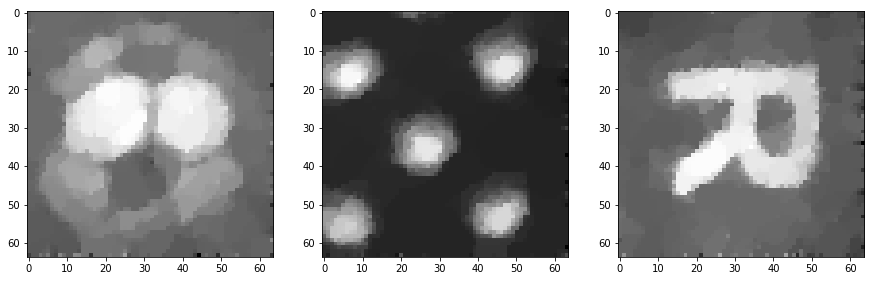

In [791]:
fig ,a = plt.subplots(1,3, figsize=(15,10))
a[0].imshow((val1.value).reshape(64,64),cmap='gray')
a[1].imshow((val2.value).reshape(64,64),cmap='gray')
a[2].imshow((val3.value).reshape(64,64),cmap='gray')